In [1]:
using DifferentialEquations, Plots, Rsvg, DiffEqProblemLibrary
gr()

Plots.GRBackend()

# Model and example solutions
Here we implement the gene expression model from appendix A.6 of Marchetti, Priami and Thanh, *Simulation Algorithms for Comptuational Systems Biology*, Springer (2017).

In [2]:
jprob = prob_jump_dnadimer_repressor
rn = jprob.network
rnpar = jprob.rates
varlabels = jprob.prob_data["specs_names"]
u0 = jprob.u0
tf = jprob.tstop

4000.0

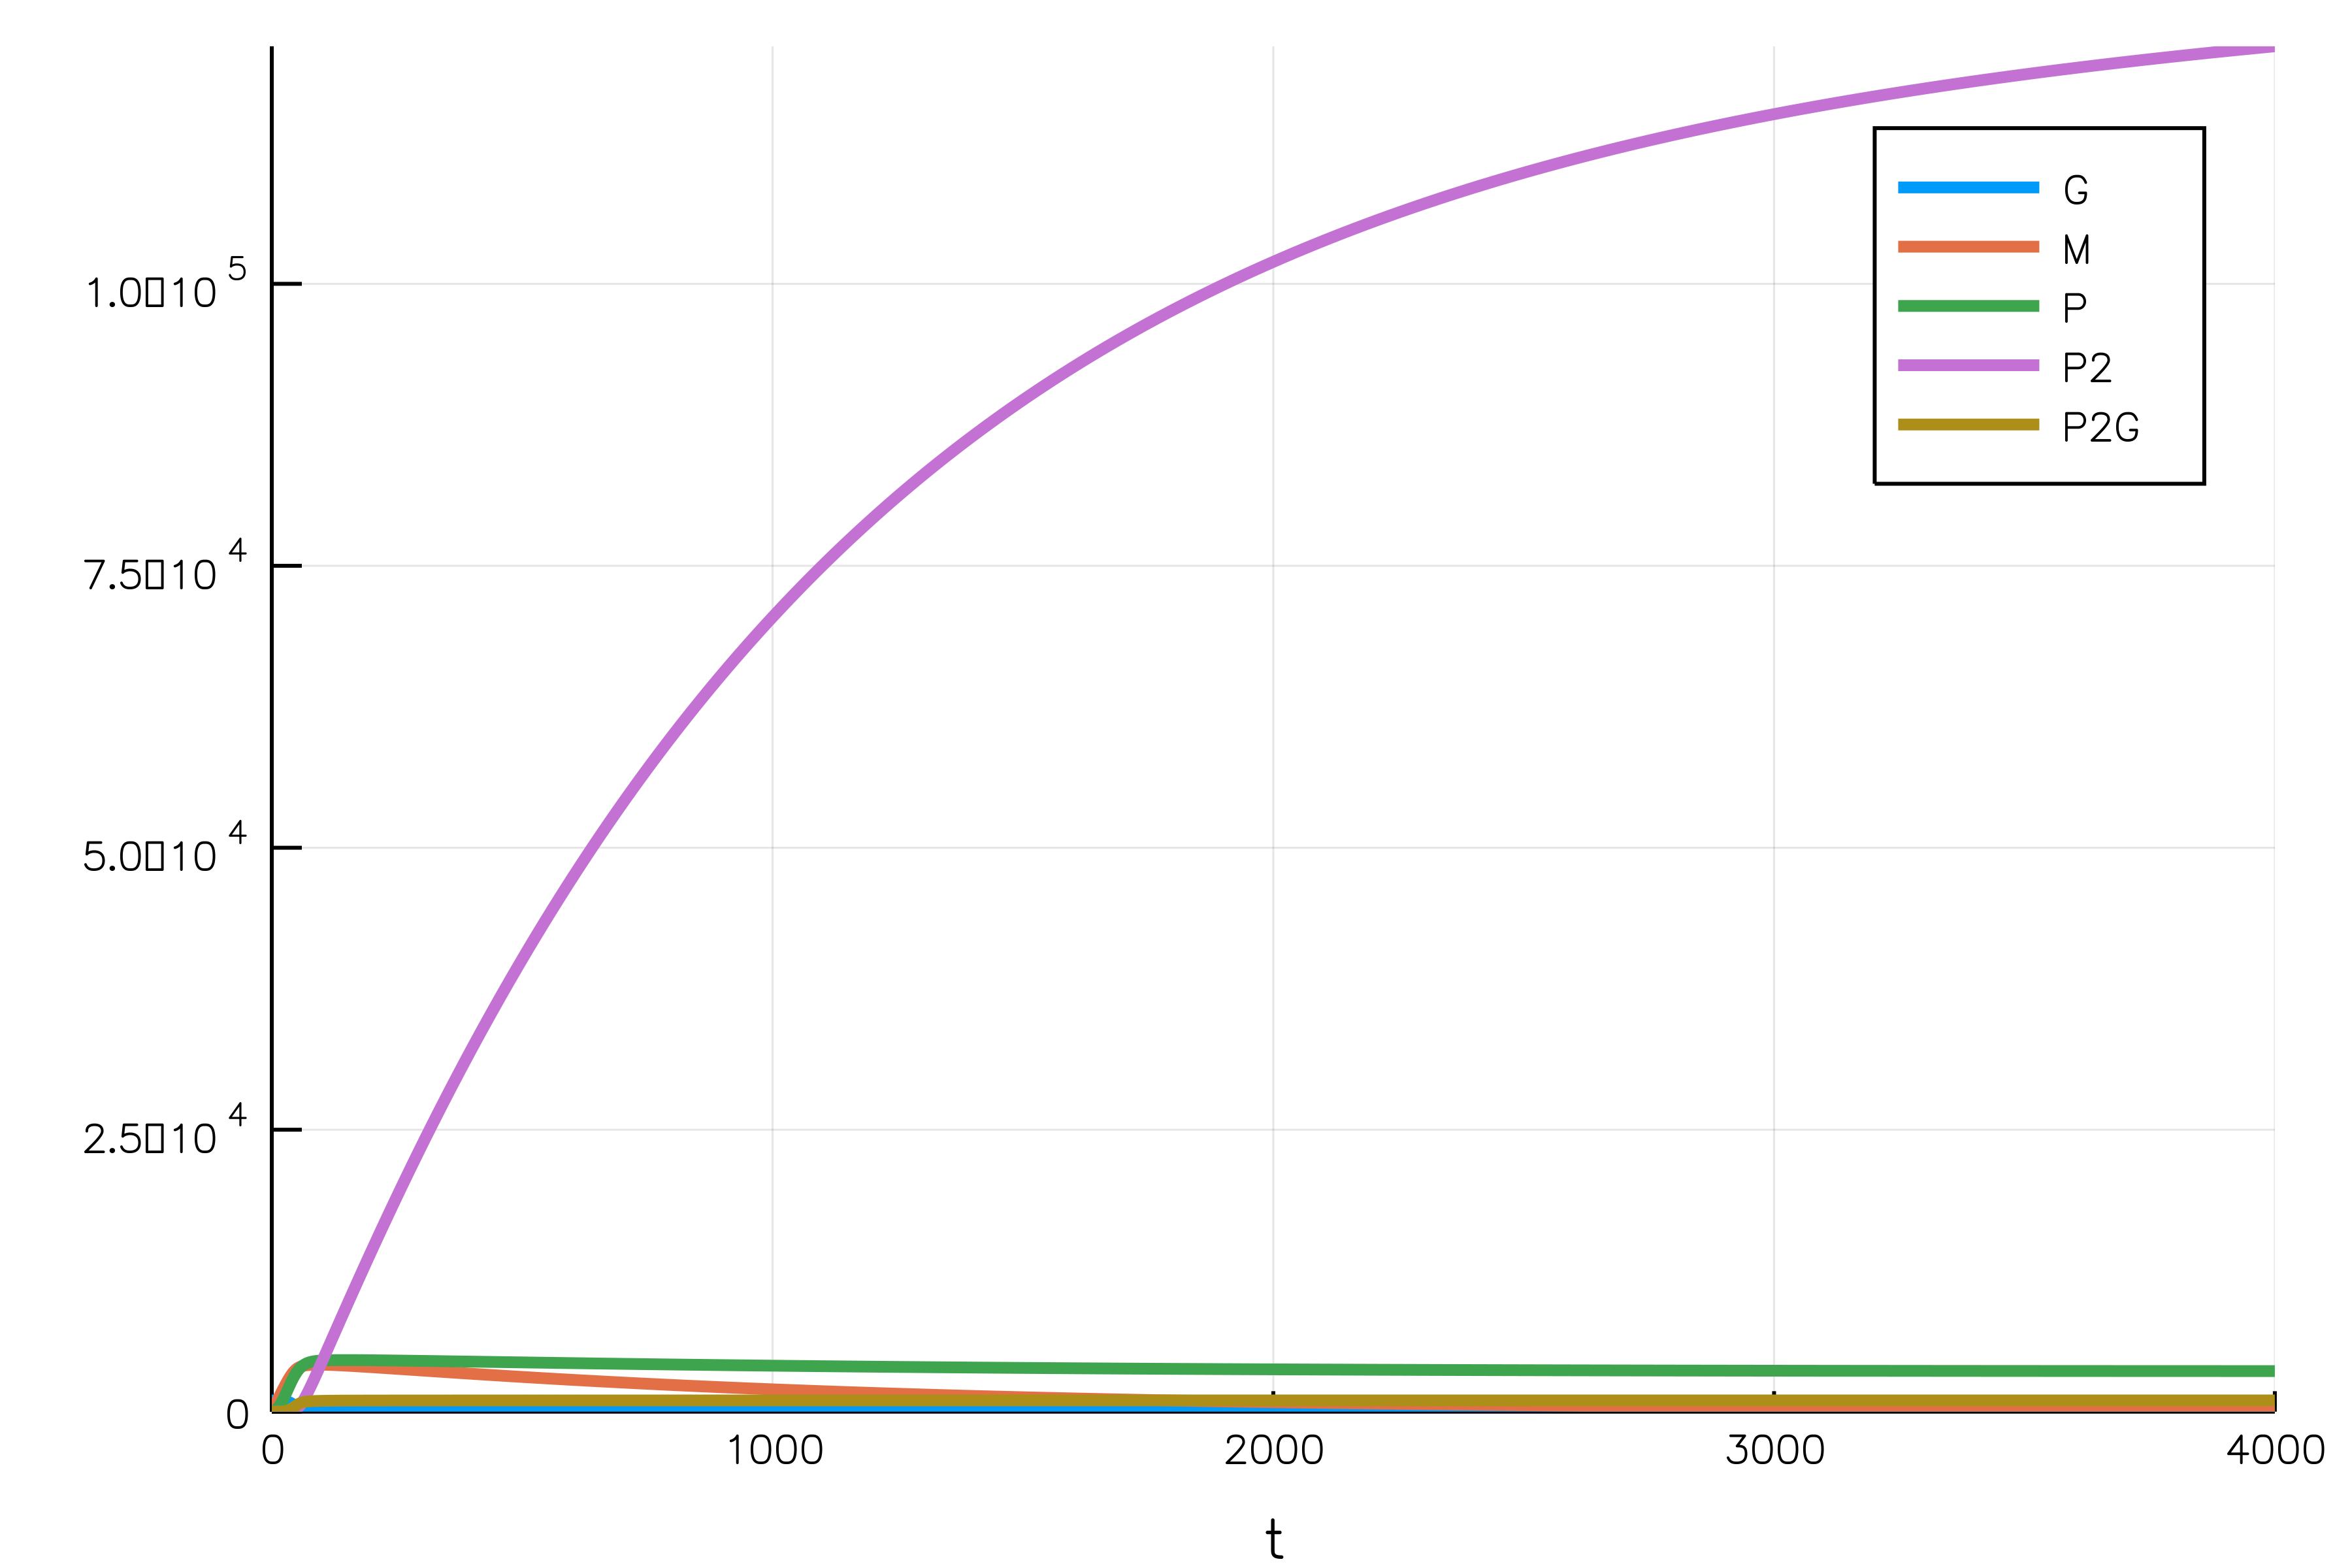

In [3]:
u0f = [1000., 0., 0., 0.,0.]
odeprob = ODEProblem(rn, u0f, (0.,tf),rnpar)
sol = solve(odeprob,Tsit5())
plot(sol, format=:png, label=varlabels)

In [4]:
ssprob = SteadyStateProblem(rn, u0f, rnpar)
ssol = solve(ssprob, DynamicSS(AutoTsit5(Rosenbrock23())))
ssol[:,end]

5-element Array{Float64,1}:
    0.896018 
   80.6416   
 4480.05     
    2.00709e5
  999.104    

In [5]:
ssprob2 = SteadyStateProblem(rn, ssol[:,end], rnpar)
ssol2 = solve(ssprob2,SSRootfind())

u: 5-element Array{Float64,1}:
    0.896011 
   80.641    
 4480.05     
    2.00709e5
  999.096    

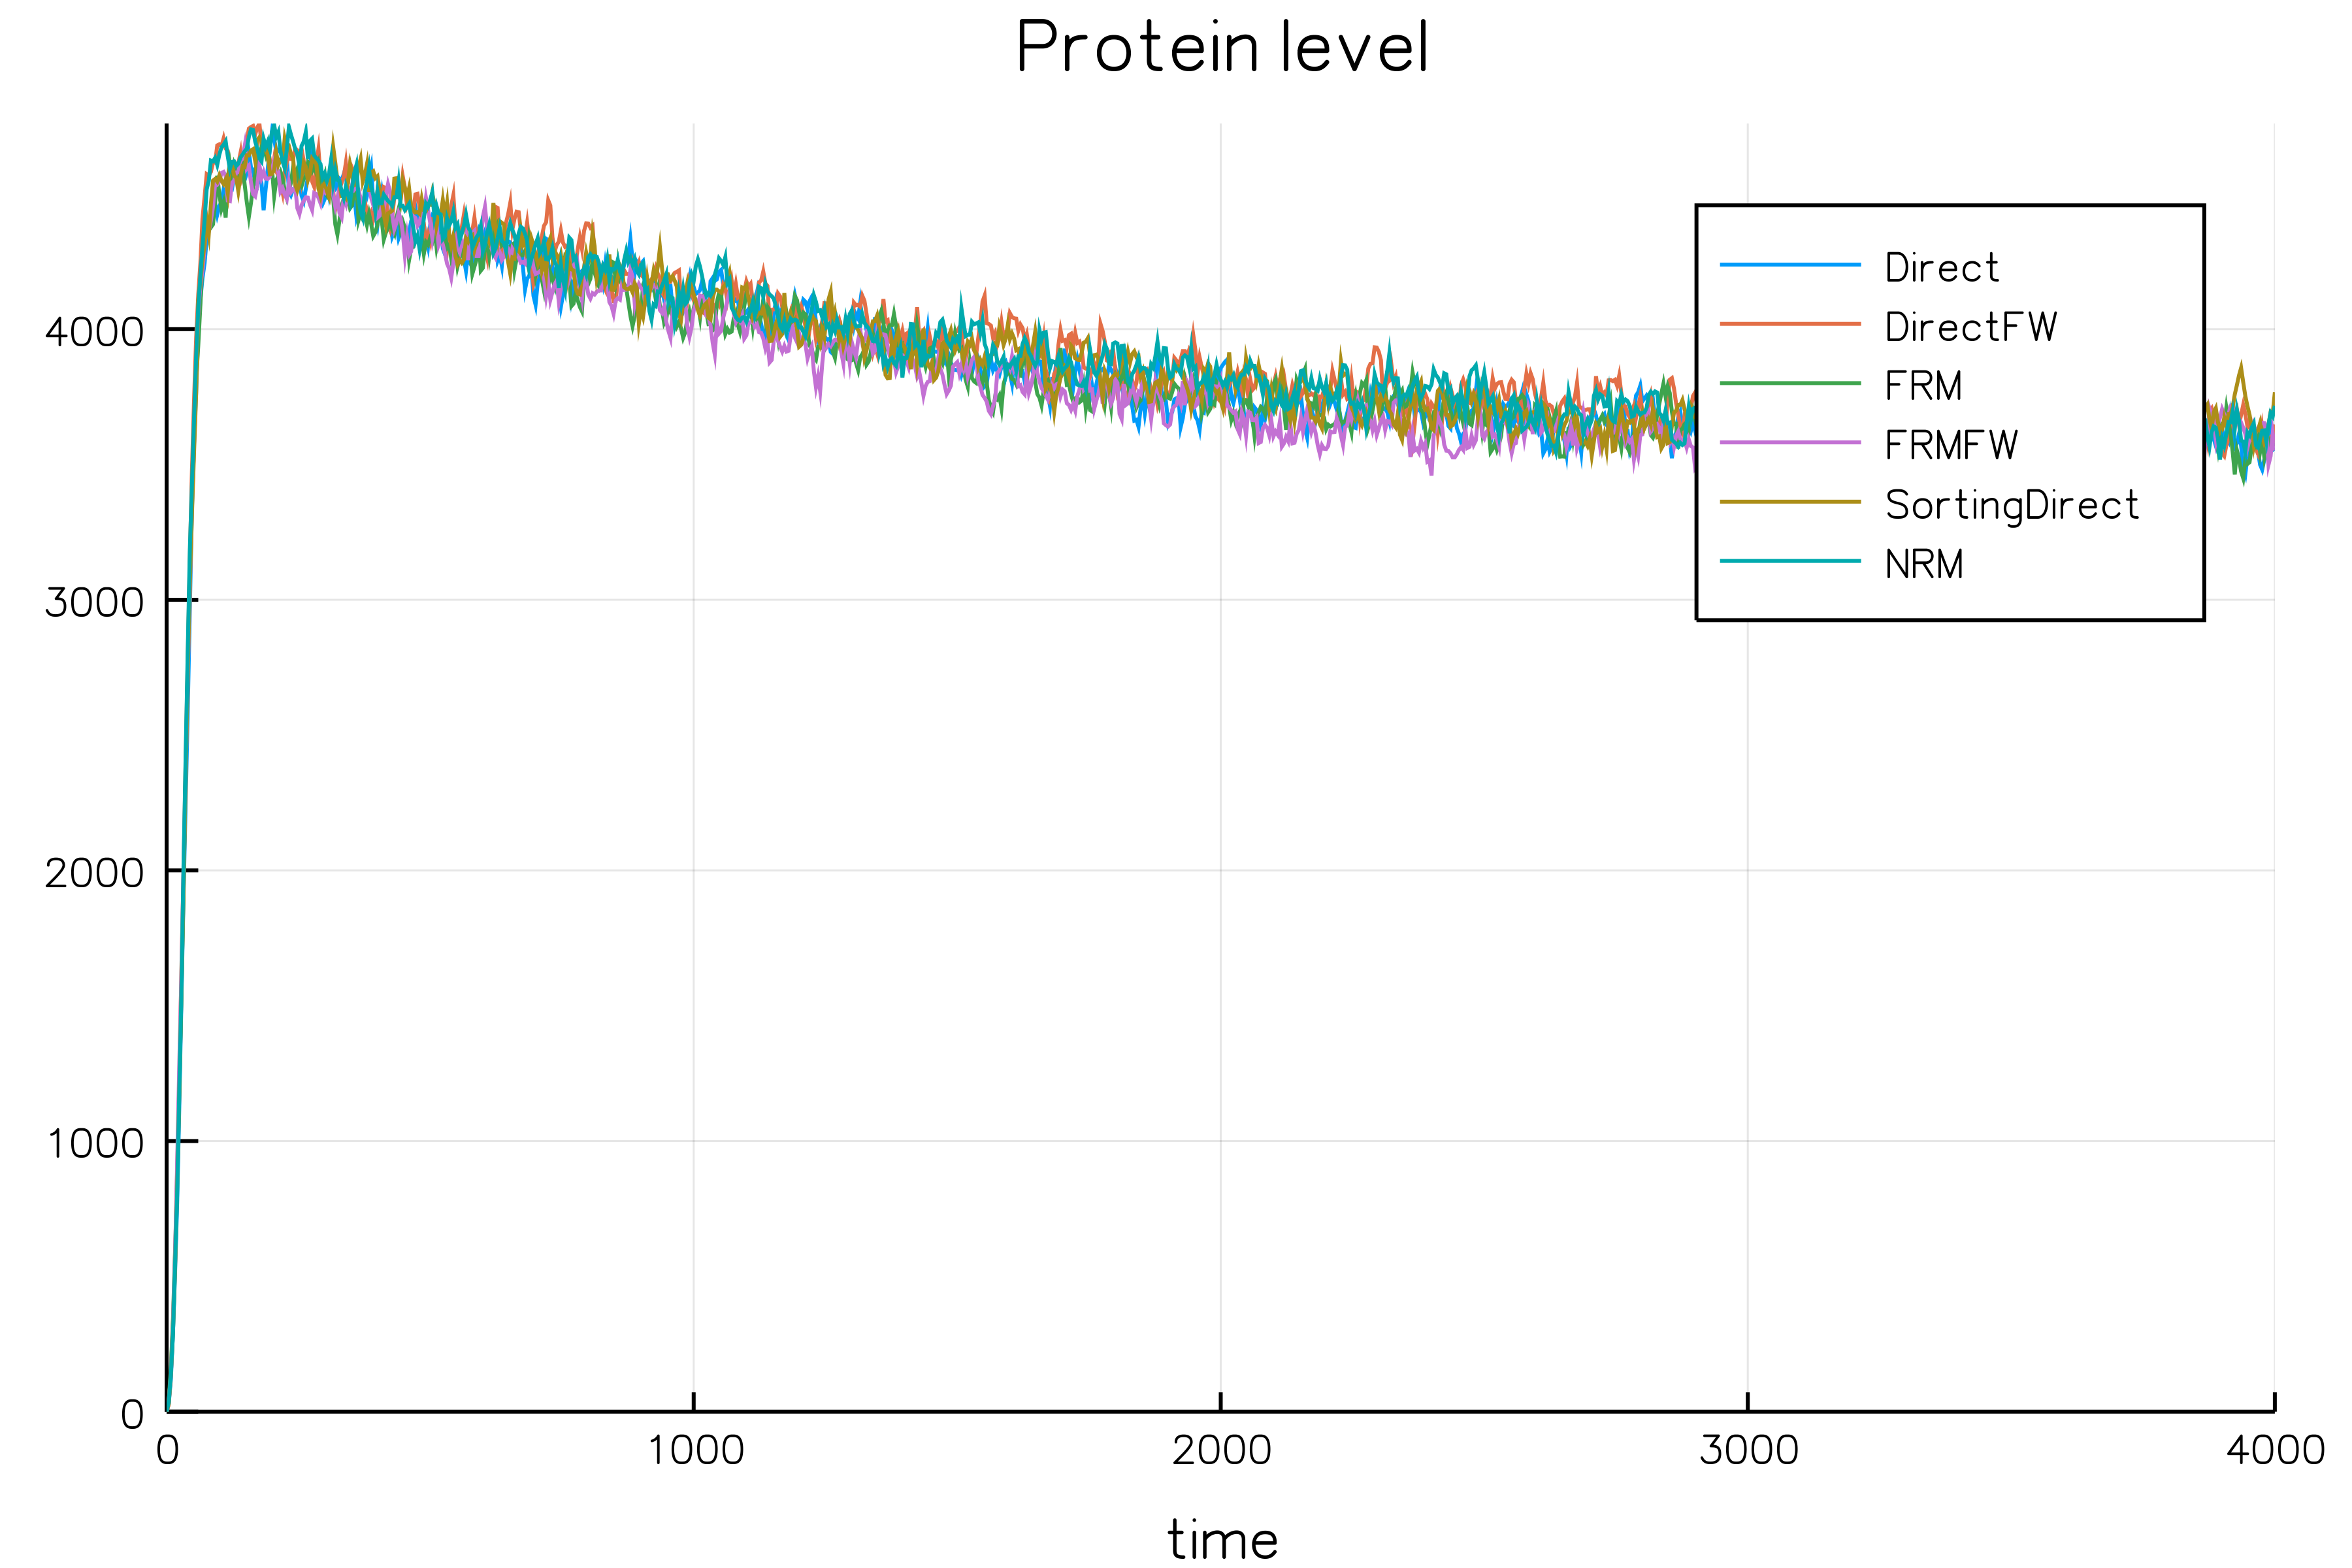

In [6]:
tf      = 4000.
methods = (Direct(),DirectFW(),FRM(),FRMFW(),SortingDirect(),NRM())
legs    = [typeof(method) for method in methods]
shortlabels = [string(leg)[12:end] for leg in legs]
fmt     = :png
prob    = prob = DiscreteProblem(u0, (0.0, tf), rnpar)
ploth   = plot(reuse=false)
p = []
for (i,method) in enumerate(methods)
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper(), saveat=tf/1000.)
    plot!(ploth,sol.t,sol[3,:],label=shortlabels[i], format=fmt)
    push!(p, plot(sol,title=shortlabels[i],leg=false,format=fmt))
end
plot(ploth, title="Protein level", xlabel="time",format=fmt)

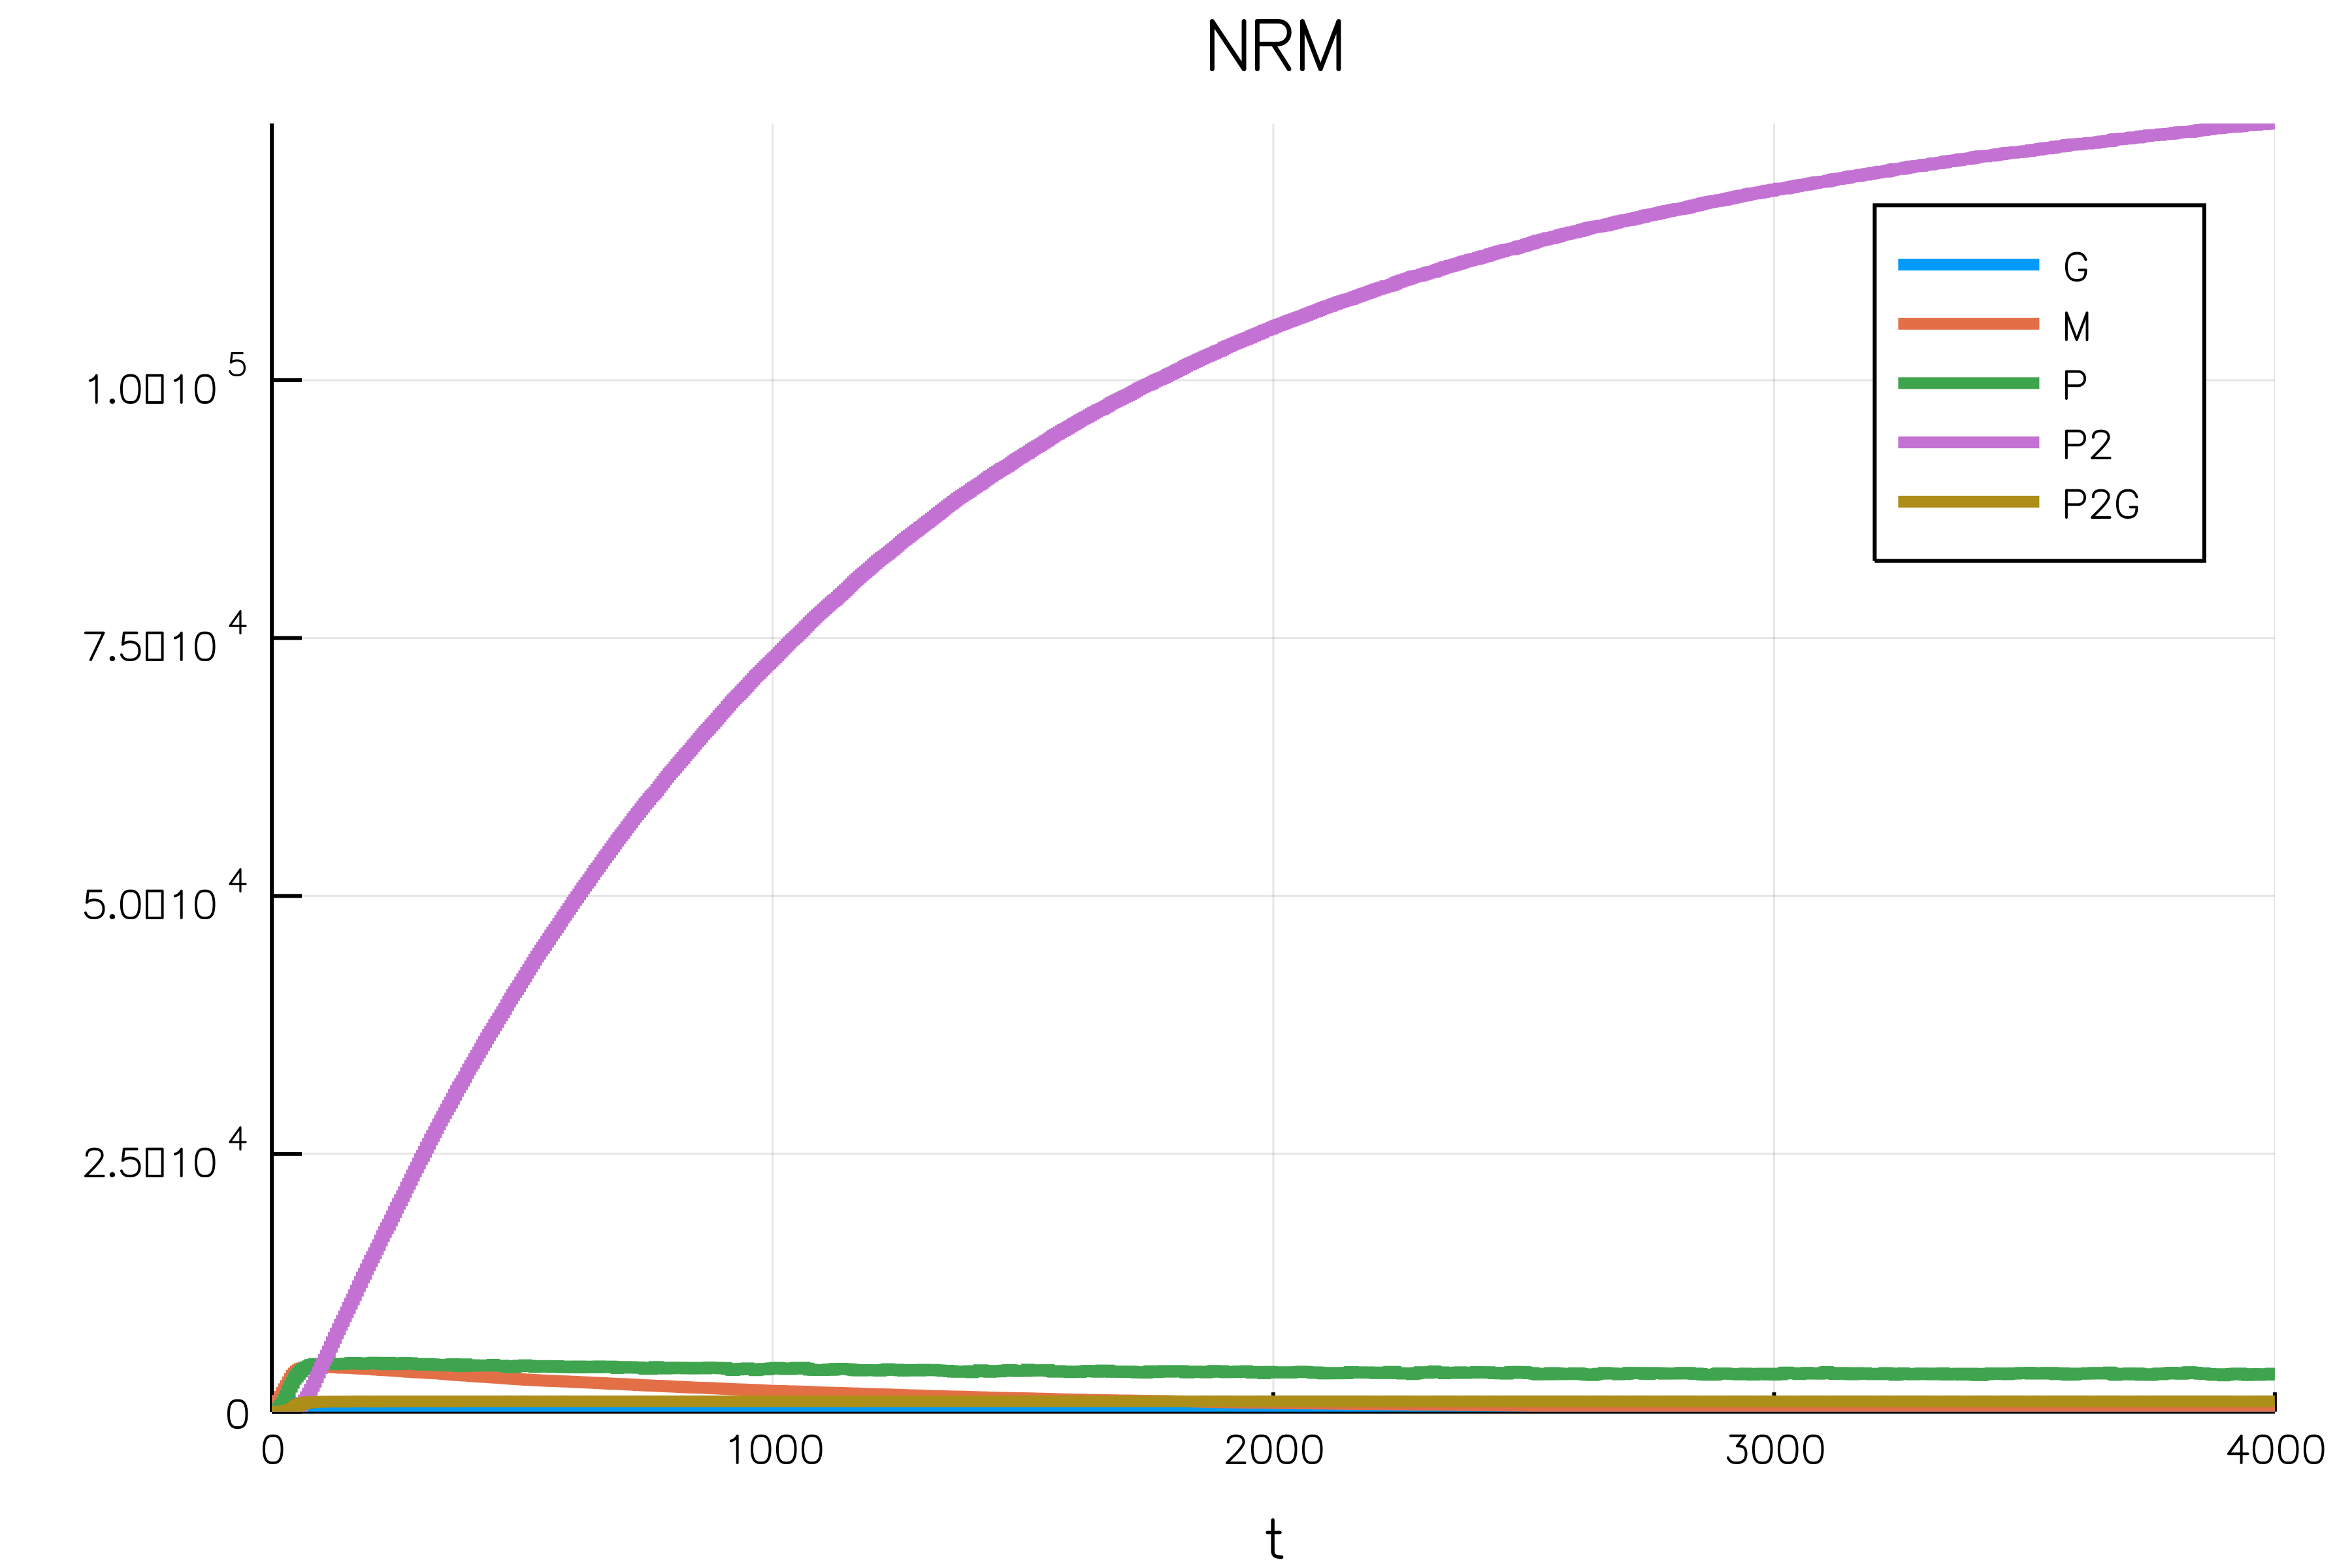

In [7]:
plot(p[end],format=fmt,legend=true,labels=varlabels)

# Benchmarking performance of the methods

In [12]:
using BenchmarkTools
benchmarks = []
# turn off saving solution
for method in methods
    jump_prob = JumpProblem(prob, method, rn, save_positions=(false,false))
    sol = solve(jump_prob, SSAStepper())    
    push!(benchmarks, @benchmark (for i = 1:5; solve($jump_prob, $SSAStepper()); end))
end

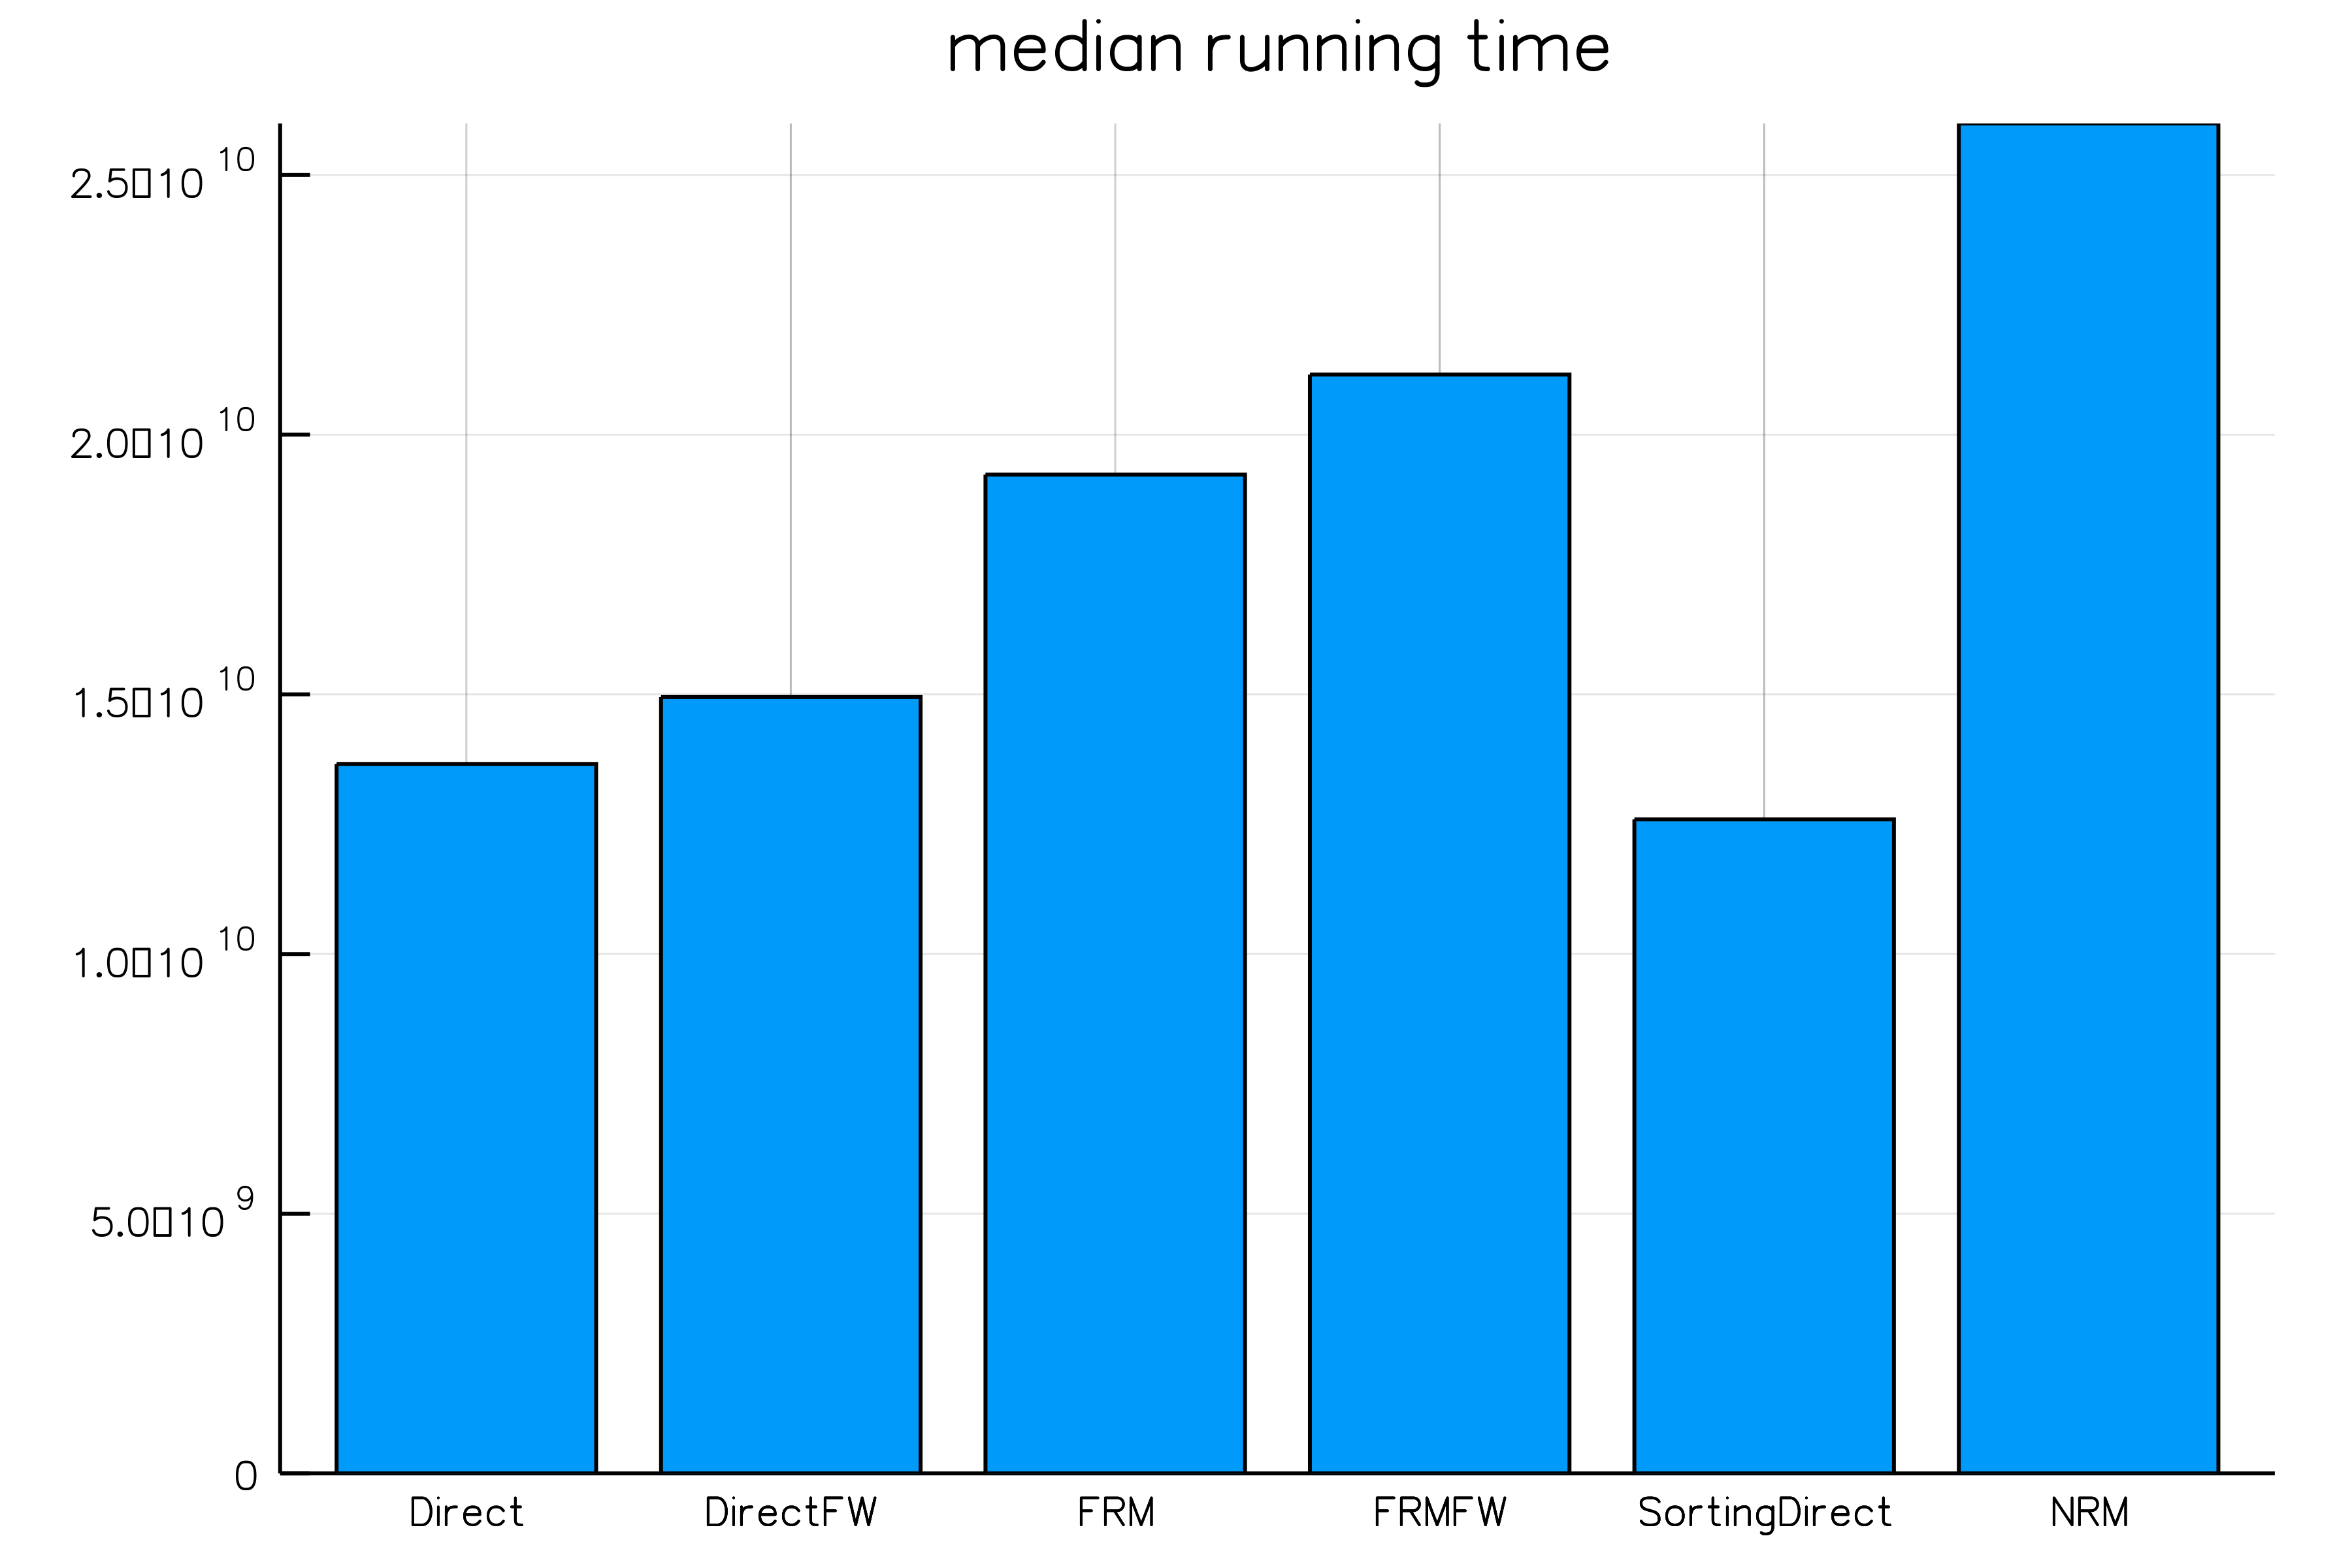

In [13]:
medtimes = [median(b.times) for b in benchmarks]
bar(shortlabels,medtimes,title="median running time",leg=false,format=fmt)

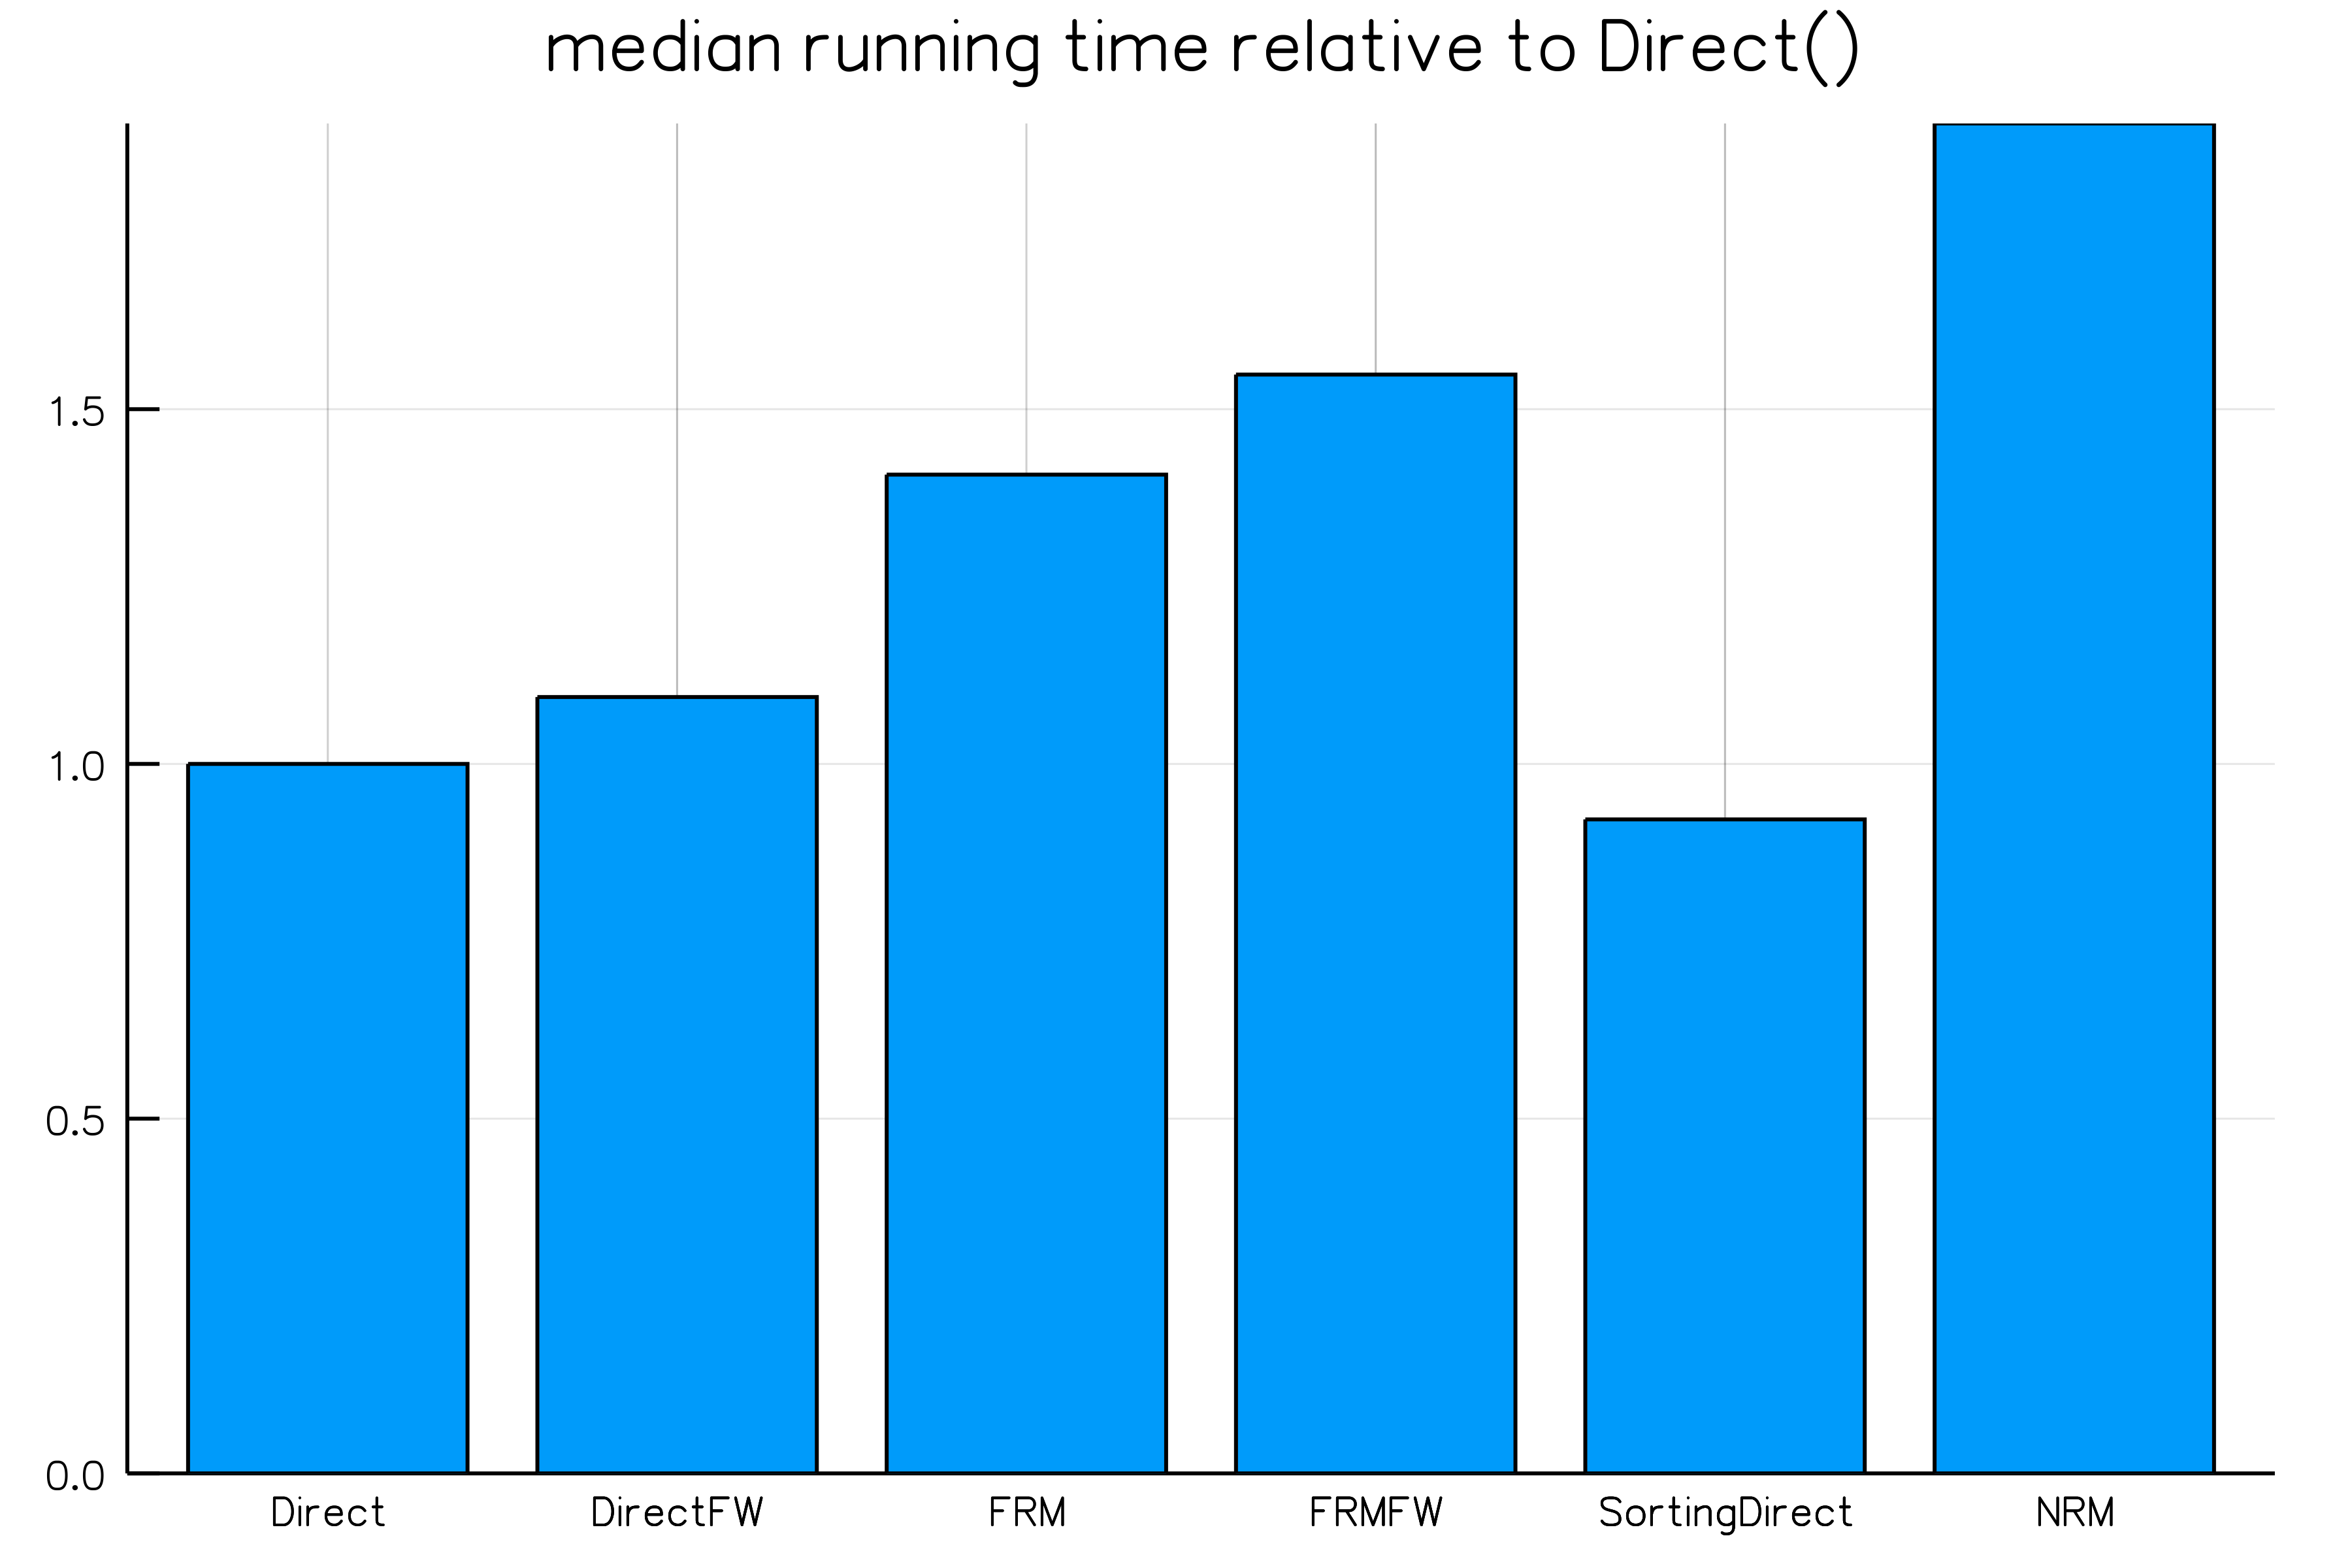

In [14]:
relmed = medtimes / medtimes[1]
bar(shortlabels,relmed,title="median running time relative to Direct()",leg=false,format=fmt)

In [15]:
using DataFrames
# convert times to units of seconds
df = DataFrame(names=shortlabels,medtimes=(medtimes/1e9),relmedtimes=relmed)

6×3 DataFrames.DataFrame
│ Row │ names         │ medtimes │ relmedtimes │
├─────┼───────────────┼──────────┼─────────────┤
│ 1   │ Direct        │ 13.6605  │ 1.0         │
│ 2   │ DirectFW      │ 14.9489  │ 1.09431     │
│ 3   │ FRM           │ 19.2308  │ 1.40776     │
│ 4   │ FRMFW         │ 21.1571  │ 1.54878     │
│ 5   │ SortingDirect │ 12.5921  │ 0.92179     │
│ 6   │ NRM           │ 25.9921  │ 1.90271     │